
# ASLA-Leap Dataset
[Download]()
## A dataset of American Sign Language Alphabet Collected with a Leap Motion Controller
<img src="setup.png" width="80%">
from [American Sign Language Alphabet Recognition Using Leap Motion Controller](https://taowenjin.com/papers/American-sign-language-alphabet-recognition-using-leap-motion-controller.html)

In [ ]:
%matplotlib inline

import numpy as np
import cv2 

import glob
import pandas as pd

import ctypes, os, sys

import Leap
import pickle

from leap_data_helper import *

import matplotlib.pyplot as plt

: 

## Let's disgard the first 50 frames because there're some noises inside.

In [2]:
def load_data(data_files, n_disgard=50):
    data_file_names = glob.glob(data_files)
    data_file_names.sort()
    return data_file_names[n_disgard:]

In [3]:
person_id = 'p_0'
gesture_id = 'd'
num_disgard = 50

img_leap_l_names = load_data('./'+person_id+'/'+gesture_id+'/leap_raw_images/*_left.npy', num_disgard )
img_leap_r_names = load_data('./'+person_id+'/'+gesture_id+'/leap_raw_images/*_right.npy', num_disgard )

frame_leap_names = load_data('./'+person_id+'/'+gesture_id+'/leap_frames/*.data', num_disgard )

In [4]:
len(img_leap_l_names)

450

In [17]:
#img_leap_l_names

In [6]:
data_file = './distortion_map.p'

with open(data_file, mode='rb') as f:
    data = pickle.load(f)#, encoding='latin1')
    left_coordinates = data['left_coordinates']
    left_coefficients = data['left_coefficients']
    right_coordinates = data['right_coordinates']
    right_coefficients = data['right_coefficients']

In [7]:
def undistort(image, coordinate_map, coefficient_map, width, height):
    destination = np.empty((width, height), dtype = np.ubyte)

#     #wrap image data in numpy array
#     i_address = int(image.data_pointer)
#     ctype_array_def = ctypes.c_ubyte * image.height * image.width
#     # as ctypes array
#     as_ctype_array = ctype_array_def.from_address(i_address)
#     # as numpy array
#     as_numpy_array = np.ctypeslib.as_array(as_ctype_array)
#     img = np.reshape(as_numpy_array, (image.height, image.width))

    #remap image to destination
    destination = cv2.remap(image,
                            coordinate_map,
                            coefficient_map,
                            interpolation = cv2.INTER_LINEAR)

    #resize output to desired destination size
    destination = cv2.resize(destination,
                             (width, height),
                             0, 0,
                             cv2.INTER_LINEAR)
    return destination


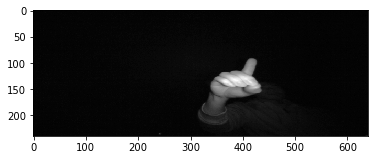

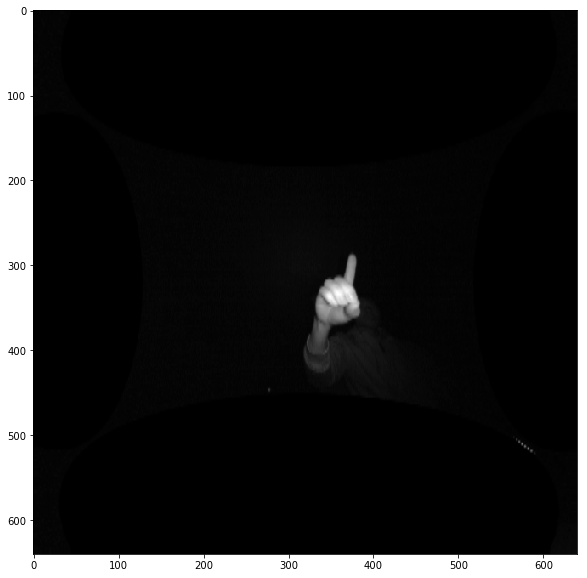

In [8]:
img = np.load(img_leap_l_names[np.random.randint(450)])
# print img.shape
plt.imshow(img, 'gray')

img = undistort(img, left_coordinates, left_coefficients, 640, 640)
img = cv2.flip(img, 1)
plt.figure(figsize=(10,10))
plt.imshow(img, 'gray')

In [9]:
img.shape, img.max(), img.min(), img.mean()

((640, 640), 210, 0, 2.6029296875000001)

In [10]:
def hand_cropping(img):
    
    img = img[200:400, 200:400]
    
    dist_x = np.sum(img,0)
    dist_y = np.sum(img,1)
    span_x = np.where(dist_x>500)
    span_x_start = np.min(span_x)
    span_x_end = np.max(span_x)
    span_y = np.where(dist_y>50)
    span_y_start = np.min(span_y)
    span_y_end = np.max(span_y)
    
    if len(span_y[0])/len(span_x[0]) > 2:
        span_y_end = int(span_y_start + len(span_x[0])*1.8)
    return img[span_y_start:span_y_end+1,span_x_start:span_x_end+1]

In [11]:
img_test = np.copy(img)

(-0.5, 95.5, 95.5, -0.5)

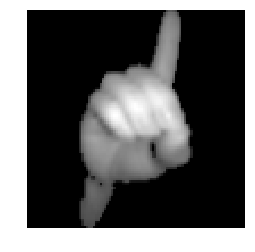

In [13]:
img_test[img_test<60] = 0
img_test = hand_cropping(img_test)
img_test = np.expand_dims(img_test, 2)
img_test = resize_img(img_test, 96)
plt.imshow(img_test,'gray')

plt.axis('off')

## Let's work on the skeleton data

In [14]:
def cal_2vec_angle(v1, v2):
    # return the value of cos(angle)
    return np.dot(v1,v2)/np.linalg.norm(v1)/np.linalg.norm(v2)


def get_frame(filename):
    
    frame = Leap.Frame()
    # filename = 'cali_1495553181022000.data'
    with open(os.path.realpath(filename), 'rb') as data_file:
        data = data_file.read()

    leap_byte_array = Leap.byte_array(len(data))
    address = leap_byte_array.cast().__long__()
    ctypes.memmove(address, data, len(data))

    frame.deserialize((leap_byte_array, len(data)))
    
    return frame


# Let's have a quick validation of the frame data
def get_joints(frame):
    joints=[]
    for hand in frame.hands:
        for finger in hand.fingers:
            for b in range(0, 4):
                bone = finger.bone(b)
                joint_pos = bone.next_joint.to_float_array()
                joints.append(joint_pos)
    
    return np.array(joints)


def get_angles(frame):
    
    angles = []
    # palm position
    J0 = np.array(frame.hands[0].palm_position.to_float_array())
    # thumb
    J1 = np.array(frame.hands[0].fingers[0].bone(1).next_joint.to_float_array())
    J2 = np.array(frame.hands[0].fingers[0].bone(2).next_joint.to_float_array())
    J3 = np.array(frame.hands[0].fingers[0].bone(3).next_joint.to_float_array())
    # index
    J4 = np.array(frame.hands[0].fingers[1].bone(0).next_joint.to_float_array())
    J5 = np.array(frame.hands[0].fingers[1].bone(1).next_joint.to_float_array())
    J6 = np.array(frame.hands[0].fingers[1].bone(2).next_joint.to_float_array())
    J7 = np.array(frame.hands[0].fingers[1].bone(3).next_joint.to_float_array())
    # middle
    J8  = np.array(frame.hands[0].fingers[2].bone(0).next_joint.to_float_array())
    J9  = np.array(frame.hands[0].fingers[2].bone(1).next_joint.to_float_array())
    J10 = np.array(frame.hands[0].fingers[2].bone(2).next_joint.to_float_array())
    J11 = np.array(frame.hands[0].fingers[2].bone(3).next_joint.to_float_array())
    # ring    
    J12 = np.array(frame.hands[0].fingers[3].bone(0).next_joint.to_float_array())
    J13 = np.array(frame.hands[0].fingers[3].bone(1).next_joint.to_float_array())
    J14 = np.array(frame.hands[0].fingers[3].bone(2).next_joint.to_float_array())
    J15 = np.array(frame.hands[0].fingers[3].bone(3).next_joint.to_float_array())
    # pinky    
    J16 = np.array(frame.hands[0].fingers[4].bone(0).next_joint.to_float_array())
    J17 = np.array(frame.hands[0].fingers[4].bone(1).next_joint.to_float_array())
    J18 = np.array(frame.hands[0].fingers[4].bone(2).next_joint.to_float_array())
    J19 = np.array(frame.hands[0].fingers[4].bone(3).next_joint.to_float_array())
    
    # A1-4
    A = cal_2vec_angle((J1-J0), (J4-J0))
    angles.append(A)
    A = cal_2vec_angle((J4-J0), (J8-J0))
    angles.append(A)
    A = cal_2vec_angle((J8-J0), (J12-J0))
    angles.append(A)
    A = cal_2vec_angle((J12-J0), (J16-J0))
    angles.append(A)
    
    # A5,6 on thumb
    A = cal_2vec_angle((J2-J1), (J1-J0))
    angles.append(A)
    A = cal_2vec_angle((J3-J2), (J2-J1))
    angles.append(A)
    
    # A7-9 on index
    A = cal_2vec_angle((J5-J4), (J4-J0))
    angles.append(A)
    A = cal_2vec_angle((J6-J5), (J5-J4))
    angles.append(A)
    A = cal_2vec_angle((J7-J6), (J6-J5))
    angles.append(A)
    
    # A10-12 on middle
    A = cal_2vec_angle((J9-J8), (J8-J0))
    angles.append(A)
    A = cal_2vec_angle((J10-J9), (J9-J8))
    angles.append(A)
    A = cal_2vec_angle((J11-J10), (J10-J9))
    angles.append(A)
    
    # A13-15 on ring
    A = cal_2vec_angle((J13-J12), (J12-J0))
    angles.append(A)
    A = cal_2vec_angle((J14-J13), (J13-J12))
    angles.append(A)
    A = cal_2vec_angle((J15-J14), (J14-J13))
    angles.append(A)
    
    # A16-18 on pinky
    A = cal_2vec_angle((J17-J16), (J16-J0))
    angles.append(A)
    A = cal_2vec_angle((J18-J17), (J17-J16))
    angles.append(A)
    A = cal_2vec_angle((J19-J18), (J18-J17))
    angles.append(A)
    
    # A19-22 between adjacent finger tips
    A = cal_2vec_angle((J3-J2), (J7-J6))
    angles.append(A)
    A = cal_2vec_angle((J7-J6), (J11-J10))
    angles.append(A)
    A = cal_2vec_angle((J11-J10), (J15-J14))
    angles.append(A)
    A = cal_2vec_angle((J15-J14), (J19-J18))
    angles.append(A)    
    
    return np.array(angles)

## It's time to generate the dataset

In [15]:
person_id_list = ['p_0', 'p_1', 'p_2', 'p_3', 'p_4']
gesture_id_list = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm',
                   'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y']


## Initialization
features_l_list = []
features_r_list = []
features_angles_list = []
label_list = []

# (This is a must) Create a controller to connect to the Leap Motion device
controller = Leap.Controller()

for person_id_i, person_id in enumerate(person_id_list):
    for gesture_i, gesture_id in enumerate(gesture_id_list):
        
        img_leap_l_names = load_data('./'+person_id+'/'+gesture_id+'/leap_raw_images/*_left.npy')
        img_leap_r_names = load_data('./'+person_id+'/'+gesture_id+'/leap_raw_images/*_right.npy')
        frame_leap_names = load_data('./'+person_id+'/'+gesture_id+'/leap_frames/*.data')
        
        # extract the angle features
        for frame_name in frame_leap_names:
            frame = get_frame(frame_name)
            features_angles_list.append(get_angles(frame))
                    
        # raw image left
        for img_name in img_leap_l_names:
            
            img = np.load(img_name)
            img = undistort(img, left_coordinates, left_coefficients, 640, 640)
            
            img[img<60] = 0
            
            img = hand_cropping(img)
            img = np.expand_dims(img, 2)
            img = resize_img(img, 32)
            img = normalize_data(img)
            
            features_l_list.append(img)
            label_list.append([person_id_i, gesture_i])
        
        # raw images right
        for img_name in img_leap_r_names:
            
            img = np.load(img_name)
            
            img = undistort(img, right_coordinates, right_coefficients, 640, 640)
                
            img[img<60] = 0
            
            img = hand_cropping(img)
            img = np.expand_dims(img, 2)
            img = resize_img(img, 32)
            img = normalize_data(img)
            
            features_r_list.append(img)


#             cv2.imshow('image', hand_region)
#             cv2.waitKey(5)
#             if cv2.waitKey(1) == 27:
#         #         print canvas_frame.shape
#                 break

# cv2.destroyAllWindows()

        print ((person_id + ': ' + gesture_id + ' has {} samples, label: {}').format(len(img_leap_l_names), [person_id_i, gesture_i]) )


p_0: a has 450 samples, label: [0, 0]
p_0: b has 450 samples, label: [0, 1]
p_0: c has 450 samples, label: [0, 2]
p_0: d has 450 samples, label: [0, 3]
p_0: e has 450 samples, label: [0, 4]
p_0: f has 450 samples, label: [0, 5]
p_0: g has 450 samples, label: [0, 6]
p_0: h has 450 samples, label: [0, 7]
p_0: i has 450 samples, label: [0, 8]
p_0: k has 450 samples, label: [0, 9]
p_0: l has 450 samples, label: [0, 10]
p_0: m has 450 samples, label: [0, 11]
p_0: n has 450 samples, label: [0, 12]
p_0: o has 450 samples, label: [0, 13]
p_0: p has 450 samples, label: [0, 14]
p_0: q has 450 samples, label: [0, 15]
p_0: r has 450 samples, label: [0, 16]
p_0: s has 450 samples, label: [0, 17]
p_0: t has 450 samples, label: [0, 18]
p_0: u has 450 samples, label: [0, 19]
p_0: v has 450 samples, label: [0, 20]
p_0: w has 450 samples, label: [0, 21]
p_0: x has 450 samples, label: [0, 22]
p_0: y has 450 samples, label: [0, 23]
p_1: a has 450 samples, label: [1, 0]
p_1: b has 450 samples, label: [1, 1

KeyboardInterrupt: 

## Write the data to disk

In [295]:
# Save a dictionary into a pickle file.
pickle.dump( {'features_l': np.array(features_l_list),
              'features_r': np.array(features_r_list),
              'features_angles': np.array(features_angles_list),
              'labels': np.array(label_list)} , 
            open( "./datasets/dataset.p", "wb" ),)

## Test reading

In [16]:
# data_file = './datasets/dataset.p'
# with open(data_file, mode='rb') as f:
#     data = pickle.load(f)
    
# X_l, X_r, X_angles, y = data['features_l'], data['features_r'], data['features_angles'], data['labels']

# X_l.shape, X_r.shape, X_angles.shape, y.shape